In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(666)



In [2]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    ''' creates a collection of snapshots (str) and index of a unitary op on a circuit'''
    ''' circuit_template (funct): pannylane QNode
     params (array): circuit params
     shadow_size (int) : # of snapshots
     num_qubits (int) : # of qubits in the circuit'''
    #apply single qubit Clifford circuit is equivalent to measuring Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]
    
    #sample random Pauli measurements uniformly
    
    # np.array of index for Pauli sample w/
    # \sigma_i where i=0,1,2
    unitary_ids = np.random.randint(0,3,size=(shadow_size, num_qubits))
    
    # np.array of measurement outcomes (-1,1)
    outcomes = np.zeros((shadow_size, num_qubits))
    
    for i in range(shadow_size):
        obs = [unitary_ensemble[int(unitary_ids[i,j])](j) for j in range(num_qubits)]  # apply pauli op at each qubit 
        outcomes[i, :] = circuit_template(params, observable=obs)
        
    return (outcomes, unitary_ids)



In [3]:
num_qubits = 2
dev = qml.device('default.qubit', wires=num_qubits, shots=1) # shots=1 for single measurement
@qml.qnode(dev)
def local_qubit_rotation(params, **kwargs):
    obs = kwargs.pop('observable')
    for i in dev.wires:
        qml.RY(params[i], wires=i)
    return [qml.expval(i) for i in obs]

elapsed_times, shadows = [], []

params = np.random.randn(2)
for num_snap in [10, 100, 1000, 10000]:
    start = time.time()
    shadow = calculate_classical_shadow(local_qubit_rotation, params, num_snap, num_qubits)
    elapsed_times.append(time.time() - start)
    shadows.append(shadow)
    
print(shadows[0][0])
print(shadows[0][1])

[[ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1.  1.]
 [ 1. -1.]
 [ 1.  1.]
 [ 1.  1.]
 [-1. -1.]]
[[2 2]
 [1 2]
 [0 1]
 [2 0]
 [0 2]
 [1 0]
 [2 0]
 [1 2]
 [0 1]
 [1 1]]


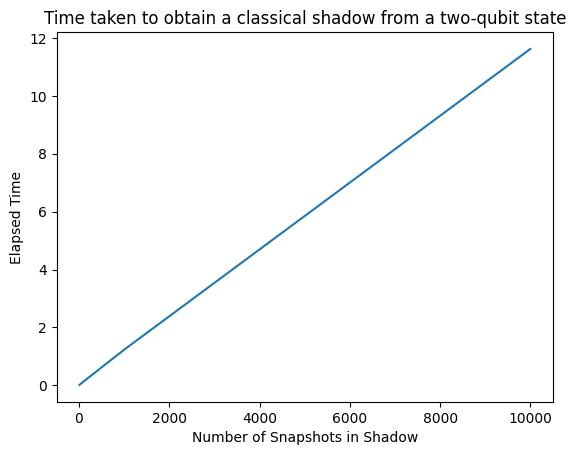

In [4]:
plt.plot([10, 100, 1000, 10000], elapsed_times)
plt.title("Time taken to obtain a classical shadow from a two-qubit state")
plt.xlabel("Number of Snapshots in Shadow")
plt.ylabel("Elapsed Time")
plt.show()

# State Reconstruction from a classical shadow

https://arxiv.org/pdf/2002.08953.pdf

adopt a random pauli basis measurement primitive,
then associated classical shadow:

$\hat{\rho} = \bigotimes^n_{j=1} ( 3 U_j^\dagger |\hat{b}_j><\hat{b}_j|-\mathbb{1}) $
where $|\hat{b}> = |\hat{b}_1> \otimes ... \otimes |\hat{b}_n> $
and $ \hat{b}_1,...,\hat{b}_n \in \{0,1\} $

In [5]:
def snapshot_state(b_list, obs_list):
    ''' args:
            b_list (array): classical outcomes
            obs_list (array): pauli indices    '''
    num_qubits = len(b_list)
    #define |0> and |1>
    zero_state = np.array([[1, 0], [0, 0]])
    one_state = np.array([[0, 0], [0, 1]])
    
    phase_z = np.array([[1, 0], [0, -1j]], dtype=complex)
    hadamard = qml.matrix(qml.Hadamard(wires=0))
    identity = qml.matrix(qml.Identity(wires=0))
    #undo rotations that were added implicitly to the circuit for pauli measurements
    unitaries = [hadamard, hadamard @ phase_z, identity]
    
    #reconstruct snapshot state
    rho_snap = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 1 else one_state
        U = unitaries[int(obs_list[i])]
        #apply the above equation
        local_rho = 3 * (U.conj().T @ state @ U) - identity
        rho_snap = np.kron(rho_snap, local_rho)
    '''numpy array of reconstructed snapshot'''
    return rho_snap
    
def shadow_state_reconstruction(shadow):
    '''arg: shadow(tuple)'''
    num_snapshots, num_qubits = shadow[0].shape
    b_lists, obs_lists = shadow

    #average over snapshot statees
    shadow_rho = np.zeros((2 ** num_qubits, 2 ** num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_lists[i], obs_lists[i])
    '''numpy array of reconstructed q state'''
    return shadow_rho / num_snapshots

In [6]:
'''example: reconstruct a bell state'''

num_qubits = 2
dev = qml.device('default.qubit', wires=num_qubits, shots=1)
@qml.qnode(dev)
def bell_state_circ(params, **kwargs):
    obs = kwargs.pop('observable')
    qml.Hadamard(0)
    qml.CNOT(wires=[0,1])
    return [qml.expval(i) for i in obs]

#construct classical shadow w/ 1000 snapshots
num_snapshots = 1000
params = []
shadow = calculate_classical_shadow(bell_state_circ, params, num_snapshots, num_qubits)

print(shadow[0])
print(shadow[1])

[[ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 ...
 [ 1. -1.]
 [-1.  1.]
 [ 1.  1.]]
[[1 0]
 [0 1]
 [2 0]
 ...
 [1 1]
 [1 1]
 [0 2]]


In [7]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=5))

[[ 0.50275+0.j       0.0285 -0.02325j  0.06375+0.j       0.4995 -0.00675j]
 [ 0.0285 +0.02325j -0.01925+0.j       0.027  -0.00675j -0.04425-0.018j  ]
 [ 0.06375-0.j       0.027  +0.00675j -0.05675+0.j       0.006  +0.00375j]
 [ 0.4995 +0.00675j -0.04425+0.018j    0.006  -0.00375j  0.57325+0.j     ]]


In [8]:
def norm_op(R):
    ''' calculate the operator 2-norm
    arg: R(array) the operator   '''
    return np.sqrt(np.trace(R.conjugate().transpose() @ R))

In [9]:
bell_state_theory = np.array([[0.5, 0, 0, 0.5], [0, 0, 0, 0], [0, 0, 0, 0], [0.5, 0, 0, 0.5]])

norm_op(bell_state_theory - shadow_state)


(0.16156422871415568+0j)


print('bell theoric', type(bell_state_theory))
print('bell shape ', bell_state_theory.shape)
print('shadow type ', type(shadow_state))
print('shadow shape ', shadow_state.shape)
R = bell_state_theory - shadow_state
#R=np.subtract(bell_state_theory.numpy(), shadow_state.numpy())  # perform subtraction automatically handling data type conversion
#print(R.conjugate().transpose().shape)
#print(R.shape)

[[0.44732538 0.14305419 0.0848808 ]
 [0.51903757 0.11050566 0.05950315]
 [0.60658882 0.13932516 0.06266179]
 [0.36537652 0.17744013 0.07253103]
 [0.50675438 0.09179869 0.05517246]
 [0.63627824 0.1873099  0.07845221]
 [0.47037219 0.13434284 0.06961052]
 [0.4350862  0.19666215 0.04610721]
 [0.56431374 0.19468436 0.04941154]
 [0.35348267 0.13022673 0.05129327]]


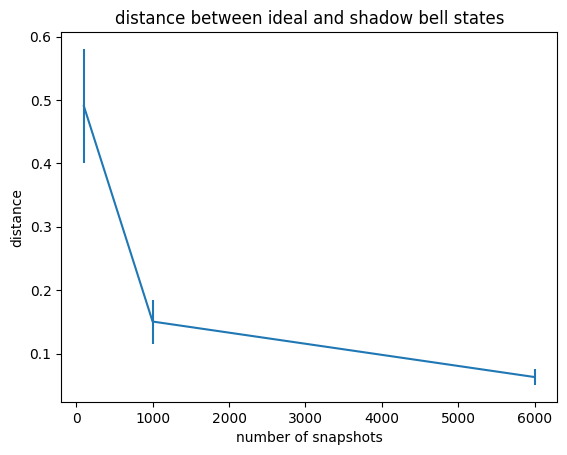

In [10]:
num_o_runs = 10
snapshot_range = [100, 1000, 6000]
distances = np.zeros((num_o_runs, len(snapshot_range)))

# run multiple estimations
for i in range(num_o_runs):
    for j, num_snapshots in enumerate(snapshot_range):
        shadow = calculate_classical_shadow(bell_state_circ, params, num_snapshots, num_qubits)
        shadow_state = shadow_state_reconstruction(shadow)
        distances[i,j] = np.real(norm_op(bell_state_theory - shadow_state))
print(distances)    
plt.errorbar(snapshot_range, np.mean(distances, axis=0), yerr = np.std(distances, axis=0))
plt.title('distance between ideal and shadow bell states')
plt.xlabel('number of snapshots')
plt.ylabel('distance')
plt.show()

# estimate pauli observables with classical shadows

In [11]:
def estimate_shadow_observable(shadow, observable, k=10):
    '''estimator E[O] = median(tr{rho_{(k)} O}) where rho_k is set of k snaps in the shadow
    args:
        shadow (tuple)
        observable (qml.Observable)
        k (int): num of splits in the median of means estimator'''
    shadow_size, num_qubits = shadow[0].shape
    map_name_to_int = {'PauliX': 0, 'PauliY':1, 'PauliZ':2}
    if isinstance(observable, (qml.PauliX, qml.PauliY, qml.PauliZ)):
        target_obs, target_locs = np.array([map_name_to_int[observable.name]]), np.array([observable.wires[0]])    
    else:
        target_obs, target_locs = np.array([map_name_to_int[i.name] for i in observable.obs]), np.array([i.wires[0] for i in observable.obs])
    b_lists, obs_lists = shadow
    means = []
    
    # loop over splits of shadow
    for i in range(0, shadow_size, shadow_size//k):
        b_lists_k, obs_lists_k = (b_lists[i : i+shadow_size//k], obs_lists[i : i+shadow_size//k])
        #find exact matches for the obs of interest at the specified location
        indices = np.all(obs_lists_k[:, target_locs] == target_obs, axis=1)
        #catch the edge case where there is no match in the chunk
        if sum(indices)>0:
            product = np.prod(b_lists_k[indices][: , target_locs], axis=1)
            means.append(np.sum(product)/sum(indices))
        else:
            means.append(0)
    return np.median(means)
    

In [12]:
def shadow_bound(error, obs, failure_rate=0.01):
    '''args:
    error (float): error on the estimator
    obs (list)
    failure_rate (float)'''
    M = len(obs)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (lambda op: np.linalg.norm(op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf)**2)
    N = 34 * max(shadow_norm(i) for i in obs) / error ** 2
    return int(np.ceil(N * K)), int(K)

In [13]:
num_qubits = 10
dev = qml.device("default.qubit", wires=num_qubits, shots=1)


@qml.qnode(dev)
def circuit(params, **kwargs):
    observables = kwargs.pop("obs")
    for w in range(num_qubits):
        qml.Hadamard(wires=w)
        qml.RY(params[w], wires=w)
    for w in dev.wires[:-1]:
        qml.CNOT(wires=[w, w + 1])
    for w in dev.wires:
        qml.RZ(params[w + num_qubits], wires=w)
    return [qml.expval(o) for o in observables]


params = np.random.randn(2 * num_qubits)

In [14]:
list_of_observables = (
    [qml.PauliX(i) @ qml.PauliX(i + 1) for i in range(num_qubits - 1)]
    + [qml.PauliY(i) @ qml.PauliY(i + 1) for i in range(num_qubits - 1)]
    + [qml.PauliZ(i) @ qml.PauliZ(i + 1) for i in range(num_qubits - 1)]
)

$ |<O_i>_{shadow} - <O_i>_{exact}| \leq \epsilon $

$ \forall \; 1\leq i \leq M $

In [15]:
shadow_size_bound, k = shadow_bound(error=2e-1, obs=[qml.matrix(i) for i in list_of_observables])
shadow_size_bound

14611

In [16]:
# create a grid of errors
epsilon_grid = [1 - 0.1 * x for x in range(9)]
shadow_sizes, estimates = [], []

for error in epsilon_grid:
    # get number of samples necessary to error < epsilon
    shadow_size_bound, k = shadow_bound(error=error, obs=[qml.matrix(i) for i in list_of_observables])
    shadow_sizes.append(shadow_size_bound)
    print(f'{shadow_size_bound} samples required')
    #calculate a shadow of the appropriate size
    shadow = calculate_classical_shadow(circuit, params, shadow_size_bound, num_qubits)
    #estimate all obs
    estimates.append([estimate_shadow_observable(shadow, i, k=k) for i in list_of_observables])

585 samples required


KeyError: 'obs'

In [ ]:
dev_exact = qml.device('default.qubit', wires=num_qubits)
circuit.device = dev_exact
expval_exact = [circuit(params, wires=dev_exact.wires, obs=[i]) for i in list_of_observables]

In [ ]:
for j, error in enumerate(epsilon_grid):
    plt.scatter(
        [shadow_sizes[j] for _ in estimates[j]],
        [np.abs(obs - estimates[j][i]) for i, obs in enumerate(expval_exact)],
        marker=".",
    )
plt.plot(
    shadow_sizes,
    [e for e in epsilon_grid],
    linestyle="--",
    color="gray",
    label=rf"$\epsilon$",
    marker=".",
)
plt.xlabel(r"$N$ (Shadow size) ")
plt.ylabel(r"$|\langle O_i \rangle_{exact} - \langle O_i \rangle_{shadow}|$")
plt.legend()
plt.show()